# Hypothesis Testing: Finding the Best Bidding Style

# About Project

I analysed the A/B test data of a hypothetical company to determine the best bidding type for selling a product. I found the data on [Kaggle](https://www.kaggle.com/datasets/ilkeryildiz/example-dataset-for-ab-test) and felt it would be great for practice.

#### Scenario

> A company recently introduced a new bidding type, “average bidding”, as an alternative to its existing bidding type, called “maximum bidding”. One of our clients, *anonymous.com*, has decided to test this new feature and wants to conduct an A/B test to understand if average bidding brings more conversions than maximum bidding. The A/B test has run for 1 month and anomnymous.com now expects you to analyze and present the results of this A/B test.

The test displayed the different bidding styles as advertisement campaigns to two groups. Participants in the control group viewed the maximum bidding campaigns, and those in the test group viewed the average bidding campaigns.

#### Method

I conducted a hypothesis test to determine which bidding type would increase conversions, in this case, the number of purchases.

I asked: 

**Which bidding type leads to more purchases?**

My hypotheses were: 

* **Null hypothesis**: There is no difference between the mean purchases of the control group and the test group.
* **Alternative hypothesis**: There is a difference between the mean purchases of the control group and the test group. 

Alpha = 0.05 (5%).

# Let the Analysis Begin!

## Setting up the Environment

In [43]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import figure
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm

matplotlib.rcParams['figure.figsize'] = (12,7)
sns.set()

In [44]:
control = pd.read_csv('control_group.csv')
control.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
test = pd.read_csv('test_group.csv')
test.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


In [46]:
# merge tables vertically
control_test = pd.concat([control, test], ignore_index = True, sort=False)
control_test.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaning the Data

The data needs to cleaning. Some values in the dataset are decimals instead of whole numbers, the date format is incorrect, and the names of some columns are unconventional (those with '# of '). Furthermore, the dataset has null values, and I will have to confirm if there are any duplicates.

In [47]:
control_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Campaign Name        60 non-null     object 
 1   Date                 60 non-null     object 
 2   Spend [USD]          60 non-null     int64  
 3   # of Impressions     59 non-null     float64
 4   Reach                59 non-null     float64
 5   # of Website Clicks  59 non-null     float64
 6   # of Searches        59 non-null     float64
 7   # of View Content    59 non-null     float64
 8   # of Add to Cart     59 non-null     float64
 9   # of Purchase        59 non-null     float64
dtypes: float64(7), int64(1), object(2)
memory usage: 4.8+ KB


### Check for Duplicates

In [48]:
control_test[control_test.duplicated()]

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase


Fortunately, there are no duplicates in this dataset.

### Drop Null Values

In [49]:
# discover column with null values
control_test[control_test.isnull().any(axis='columns')]

# there's no data for fifth day of the month. 
# find fifth day of the control & test groups
control_test[control_test['Date'] == '2019-08-05']

# remove fifth day from control and test groups
control_test.drop([4, 34], axis=0, inplace=True)

# confirm if columns have been removed
control_test.shape

(58, 10)

### Change Data Types

In [50]:
# change decimals to integers
control_test.loc[:, '# of Impressions':'# of Purchase'] = control_test.loc[:, '# of Impressions':'# of Purchase'].astype(int)
control_test.sample()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
18,Control Campaign,19.08.2019,2596,107890,81268,3706,2483,2098,908,542


In [51]:
# change format of date
control_test['Date'] = pd.to_datetime(control_test['Date'], format= '%d.%m.%Y')
control_test['Date'].sample()

12   2019-08-13
Name: Date, dtype: datetime64[ns]

In [52]:
# modify column names with '# of'
control_test.columns = control_test.columns.str.replace('# of ', '')
control_test.columns

Index(['Campaign Name', 'Date', 'Spend [USD]', 'Impressions', 'Reach',
       'Website Clicks', 'Searches', 'View Content', 'Add to Cart',
       'Purchase'],
      dtype='object')

In [53]:
# ensure changes were implemented
control_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 0 to 59
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Campaign Name   58 non-null     object        
 1   Date            58 non-null     datetime64[ns]
 2   Spend [USD]     58 non-null     int64         
 3   Impressions     58 non-null     int32         
 4   Reach           58 non-null     int32         
 5   Website Clicks  58 non-null     int32         
 6   Searches        58 non-null     int32         
 7   View Content    58 non-null     int32         
 8   Add to Cart     58 non-null     int32         
 9   Purchase        58 non-null     int32         
dtypes: datetime64[ns](1), int32(7), int64(1), object(1)
memory usage: 3.4+ KB


That is it as per cleaning the data.

In [54]:
# Filter out purchase column for each group and convert to numpy arrays
control_purchases = control_test.loc[control_test['Campaign Name'] == 'Control Campaign', 'Purchase']
test_purchases = control_test.loc[control_test['Campaign Name'] == 'Test Campaign', 'Purchase']

## Descriptive Statisitcs

What is the data saying? 

In [55]:
control_test.groupby('Campaign Name').agg({'Purchase': ['count', 'mean', 'std', 'var', 'min', 'median', 'max', 'skew', 'sum']})

Purchase                                                    \
                    count        mean         std           var  min median   
Campaign Name                                                                 
Control Campaign       29  522.793103  185.028642  34235.598522  222  501.0   
Test Campaign          29  512.724138  209.480633  43882.135468  238  488.0   

                                        
                  max      skew    sum  
Campaign Name                           
Control Campaign  800  0.073670  15161  
Test Campaign     890  0.157106  14869

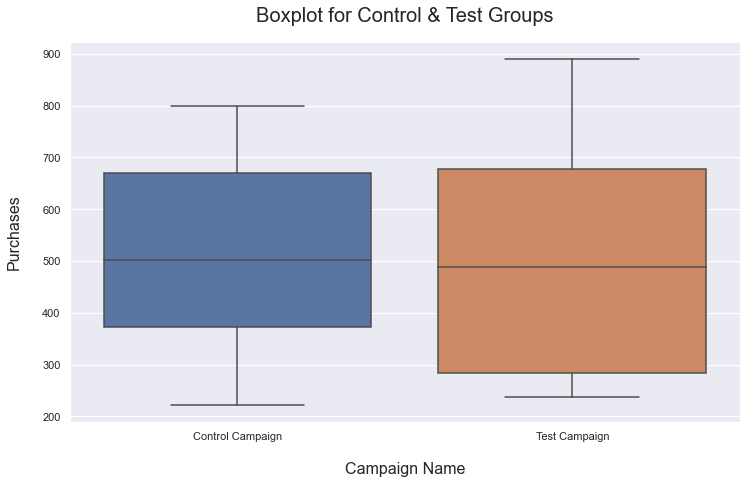

In [56]:
sns.boxplot(x='Campaign Name', y='Purchase', data=control_test)
plt.xlabel('Campaign Name', fontdict = {'fontsize': 16}, labelpad=20)
plt.ylabel('Purchases', fontdict = {'fontsize': 16}, labelpad=20)
plt.title('Boxplot for Control & Test Groups', fontdict = {'fontsize': 20}, pad=20)
plt.show()

The mean purchase of the control group is more than that of the test group. However, purchase data for the test group is more spread out. There are indications that both distributions are abnormal and skewed to the right. But, the test group has more skew than the control group. 

### The Difference between Both Groups

In [57]:
test_purchases.mean() - control_purchases.mean()

-10.068965517241281

On the surface, the control group has more purchases than the test group. The mean difference is -10. It is easy to conclude that there is no need to adopt the average bidding style. But, we need to know if this difference is significant enough or due to random chance. 

Now, the hypothesis test can come in. 

# Selecting the Hypothesis Test

The selection of the test will depend on two things: 
* The Sample size.
* The Shape of the data.

## Sample size

I calculated the sample size by summing each value in the 'Reach' column which contains data for the number of unique people who saw a particular bidding type. The sample sums up to 4,086,112 participants. Though, both groups do not have the same sample size. The control group consists of 2,576,503 people, and the test group has 1,509,609 people.

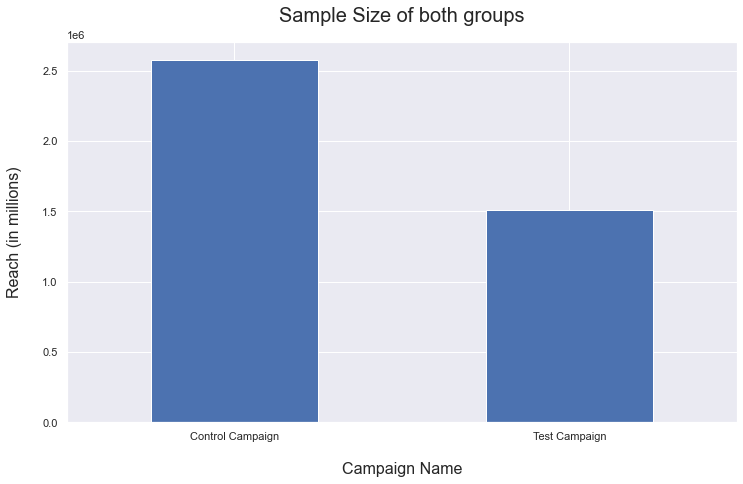

In [58]:
control_test.groupby('Campaign Name').agg({'Reach':'sum'}).plot(kind='bar')
plt.xticks(rotation = 360)
plt.xlabel('Campaign Name', fontdict = {'fontsize': 16}, labelpad=20)
plt.ylabel('Reach (in millions)', fontdict = {'fontsize': 16}, labelpad=20)
plt.title('Sample Size of both groups', fontdict = {'fontsize': 20}, pad=20)
plt.legend().remove()
plt.show()


Although the test group has fewer participants, its bidding style is more expensive to advertise. Average bidding costs $74,595, while maximum bidding costs $66,818. It begs the question: 

**Did the cost of each bidding ad affect the sample size?** 

In [59]:
# Spend of control and test groups
print('Test Spend: ', '$', control_test.loc[control_test['Campaign Name'] == 'Test Campaign', 'Spend [USD]'].sum(), '\nControl Spend: ', '$', control_test.loc[control_test['Campaign Name'] == 'Control Campaign', 'Spend [USD]'].sum())

Test Spend:  $ 74595 
Control Spend:  $ 66818


Here's another question to consider:

**Is the average bidding worth its cost?**

## Shape of the Data

### Histogram

The most common way to determine the shape of your data is by plotting it on a histogram. 

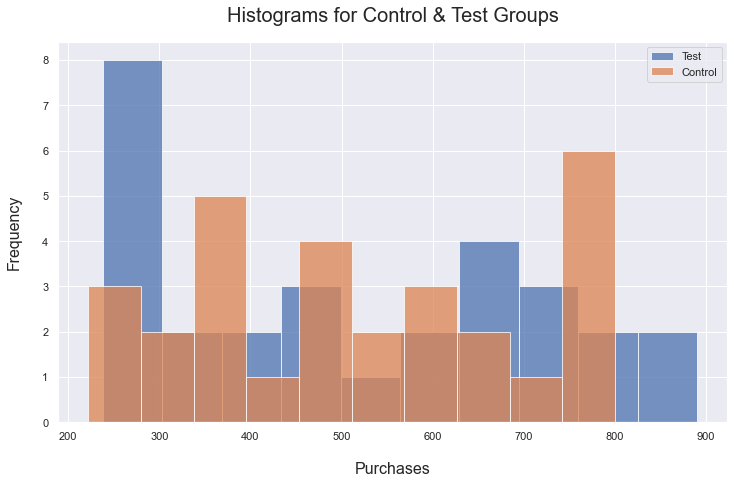

In [60]:
test_purchases.hist(alpha=0.75)
control_purchases.hist(alpha=0.75)
plt.xlabel('Purchases', fontdict = {'fontsize': 16}, labelpad=20)
plt.ylabel('Frequency', fontdict = {'fontsize': 16}, labelpad=20)
plt.title('Histograms for Control & Test Groups', fontdict = {'fontsize': 20}, pad=20)
plt.legend(['Test', 'Control'])
plt.show()

The histogram reveals that the data for both groups is abnormal. But I decided to plot the data on a quantile-quantile plot to confirm this revelation.

### Q-Q Plot

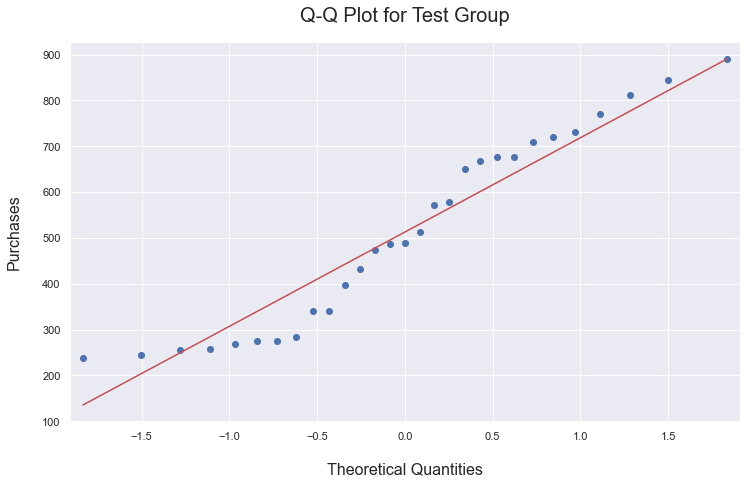

In [61]:
# Q-Q Plot for Test Group
sm.qqplot(test_purchases, line='s')
plt.title('Q-Q Plot for Test Group', fontdict = {'fontsize': 20}, pad=20)
plt.xlabel('Theoretical Quantities', fontdict = {'fontsize': 16}, labelpad=20)
plt.ylabel('Purchases', fontdict = {'fontsize': 16}, labelpad=20)
plt.show()

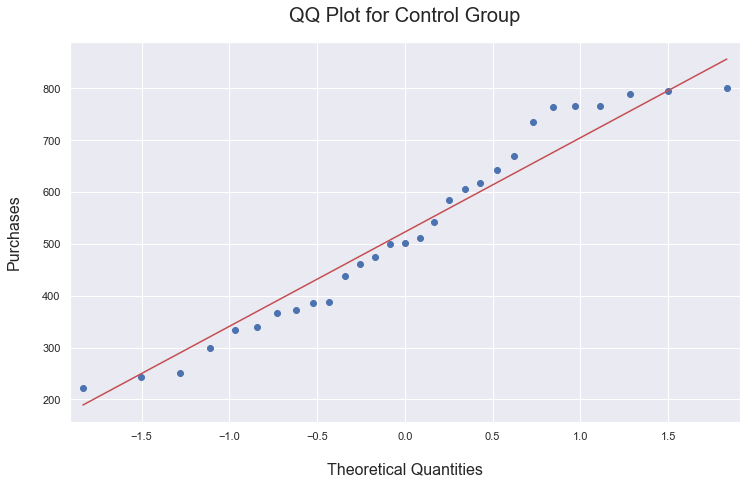

In [62]:
# Q-Q Plot for Control Group
sm.qqplot(control_purchases, line='s')
plt.title('QQ Plot for Control Group', fontdict = {'fontsize': 20}, pad=20)
plt.xlabel('Theoretical Quantities', fontdict = {'fontsize': 16}, labelpad=20)
plt.ylabel('Purchases', fontdict = {'fontsize': 16}, labelpad=20)
plt.show()

The plots confirm that the data is not normal. Both samples are close to normality but are nonetheless skewed.

## Mann-Whitney U Test: Checking for Significance


I chose to conduct the Mann-Whitney U test because it assumes that: 

1. The data is not normally distributed. 
2. The samples are independent of each other.
3. The sample size is more than 20. 

It is the appropriate statistical test for this situation since the data ticks all the assumptions. 

In [63]:
# Mann-Whitney U Test
st.mannwhitneyu(x=test_purchases, y=control_purchases, alternative = 'two-sided')

MannwhitneyuResult(statistic=405.0, pvalue=0.8155354572265037)

# Results

I got a p-value of 0.82 (82%). It is more than 0.05 (alpha). Therefore, I cannot reject the null hypothesis. 

A p-value of 82% says that: 

* The difference between the average and maximum bidding styles is not statistically significant and probably occurred due to random chance.
* There is an 82% chance that we will get a difference as big or bigger than -10.
* We are just 18% sure that the average bidding led to any real change. When you think about it, 18% is not substantial enough.

#### Limitations
* The sample size of both groups was not equal. The control group had  1,066,894 participants more than the test group. The sample's difference may likely have affected the outcome (p-value = 0.82 ). Ideally, whoever ran the test should have waited for the sample size of both groups to reach the same number before ending it. Unfortunately, I am in no position to rectify the error. 

With the available data and outcome, we can infer that there is no difference between the average bidding style and the maximum bidding style. 